In [1]:
import json
import bz2
import regex
import pymorphy2
from tqdm import tqdm
from scipy import sparse
from collections import Counter
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

[nltk_data] Downloading package punkt to /home/dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:02, 1639.37it/s] 


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

-----------------------------------------------------------------------------------------------------------------

Для начала отправим полученный результат в датафрейм, чтобы было проще анализировать данные:

In [5]:
len(responses)

153499

In [6]:
df = pd.DataFrame.from_dict(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


Ок. Теперь пройдемся по колонкам: все ли они нам нужны?

In [8]:
df['rating_not_checked'].unique()

array([False])

Значение только одно (собственно изначально так и скачивалось). Значит, этот столбец в любом случае не нужен, т.к. неинформативен. Удалим его. А остальные столбцы пока оставим.

In [9]:
df = df.drop('rating_not_checked', axis=1)
df.head()

,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


Теперь приступим к анализу.

#### 1. Посчитайте количество отзывов в разных городах и на разные банки

Сгруппируем отзывы по городам:

In [10]:
df.groupby('city')['text'].count().sort_values(ascending=False)[:30]

city
г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
г. Уфа                 1246
г. Красноярск          1236
г. москва              1217
г. Воронеж             1210
г. Пермь               1163
г. Волгоград           1014
г. Омск                 989
г. Саратов              933
г. Иркутск              749
г. Калининград          746
г. Ставрополь           696
г. Хабаровск            681
г. Тюмень               656
г. Владивосток          637
г. Барнаул              609
г. Ярославль            609
г. Тула                 586
г. Томск                569
г. Рязань               548
г. Ульяновск            500
Name: text, dtype: int64

Сразу можно увидеть, что самое большое количество отзывов написано людьми, живущими в крупных городах. При этом отзывов в городах федерального значения существенно больше, чем в других.

Теперь отдельно посмотрим на группировку по банкам:

In [11]:
df.groupby('bank_name')['text'].count().sort_values(ascending=False)[:30]

bank_name
Сбербанк России                                         26327
Альфа-Банк                                              10224
ВТБ 24                                                   8185
Русский Стандарт                                         7943
Хоум Кредит Банк                                         7549
Тинькофф Банк                                            5387
Национальный Банк «Траст»                                4607
Ренессанс Кредит                                         3849
Связной Банк                                             3775
ОТП Банк                                                 3237
Восточный Экспресс Банк                                  3138
Райффайзенбанк                                           3057
Московский Кредитный Банк                                2944
Ситибанк                                                 2848
Авангард                                                 2733
Промсвязьбанк                                            258

И снова вполне очевидный результат: первые три банка вполне ожидаемо получили лидерство по количеству отзывов по всей стране.

*Сгруппируем отзывы по городам и банкам:*

In [12]:
df_group = df.groupby(['city', 'bank_name'])['title'].count().sort_values(ascending=False)
df_group

city                                 bank_name                
г. Москва                            Сбербанк России              8146
                                     Альфа-Банк                   3871
                                     Русский Стандарт             2801
                                     ВТБ 24                       2714
г. Санкт-Петербург                   Сбербанк России              2434
                                                                  ... 
г. Москва,  Отделение "Жулебинское"  Московский Кредитный Банк       1
г. Москва, "Китай-город"             Фора-Банк                       1
г. Москва, Ветошный пер              Восточный Экспресс Банк         1
г. Москва, Видное                    Сбербанк России                 1
г. … или другой населенный пункт     Лето Банк                       1
Name: title, Length: 18769, dtype: int64

Последние строки полученной группировки значений - данные, нуждающиеся в предобработке: так, например, "г.Москва, Видное" - это ни что иное, как "г. Видное", которое имеет аж 59 обращений:

In [13]:
df[df['city'] == 'г. Видное'].shape[0]

59

А если посмотрим на банк, то увидим, что сообщений более 500:

In [14]:
df[df['bank_name'] == 'Лето Банк'].shape[0]

501

Но "грязные" данные в столбце с названиями городов не дают выделить непосредственно город и сгреппировать его с банком, поэтому мы получим ноль строк:

In [15]:
df[(df['city'] == 'г. Видное') & (df['bank_name'] == 'Лето Банк')]

,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade


При этом стоит обратить внимание, что аналогичные строки, касающиеся Москвы, существенно занижают статистику по городу. Но поскольку работа с этим столбцом не является целью данного проекта, оставим всё как есть. Однако, случись такая ситуация на работе, предобработать данные столбца было бы необходимо.  

In [16]:
df_group = df_group.reset_index()
df_group[df_group['city'] == 'г. Москва'][:10]

,city,bank_name,title
0,г. Москва,Сбербанк России,8146
1,г. Москва,Альфа-Банк,3871
2,г. Москва,Русский Стандарт,2801
3,г. Москва,ВТБ 24,2714
5,г. Москва,Московский Кредитный Банк,2348
6,г. Москва,Тинькофф Банк,2339
7,г. Москва,Хоум Кредит Банк,2143
8,г. Москва,Национальный Банк «Траст»,1654
9,г. Москва,Райффайзенбанк,1426
10,г. Москва,Связной Банк,1408


In [17]:
df_group[df_group['city'] == 'г. Санкт-Петербург'][:10]

,city,bank_name,title
4,г. Санкт-Петербург,Сбербанк России,2434
17,г. Санкт-Петербург,ВТБ 24,926
18,г. Санкт-Петербург,Альфа-Банк,867
20,г. Санкт-Петербург,Хоум Кредит Банк,711
22,г. Санкт-Петербург,Русский Стандарт,669
28,г. Санкт-Петербург,Тинькофф Банк,570
30,г. Санкт-Петербург,Ханты-Мансийский банк Открытие,430
32,г. Санкт-Петербург,Национальный Банк «Траст»,420
34,г. Санкт-Петербург,Ренессанс Кредит,418
37,г. Санкт-Петербург,Связной Банк,399


In [18]:
df_group[df_group['city'] == 'г. Казань'][:10]

,city,bank_name,title
70,г. Казань,Сбербанк России,219
122,г. Казань,Альфа-Банк,123
152,г. Казань,Хоум Кредит Банк,100
153,г. Казань,Русский Стандарт,99
228,г. Казань,ВТБ 24,71
255,г. Казань,Связной Банк,66
324,г. Казань,Тинькофф Банк,49
328,г. Казань,Ренессанс Кредит,48
354,г. Казань,Татфондбанк,44
361,г. Казань,Национальный Банк «Траст»,43


In [19]:
df_group[df_group['city'] == 'г. Новосибирск'][:10]

,city,bank_name,title
35,г. Новосибирск,Сбербанк России,404
62,г. Новосибирск,Альфа-Банк,248
97,г. Новосибирск,ВТБ 24,155
108,г. Новосибирск,Русский Стандарт,136
117,г. Новосибирск,Хоум Кредит Банк,127
179,г. Новосибирск,МДМ Банк,86
207,г. Новосибирск,ОТП Банк,76
224,г. Новосибирск,Тинькофф Банк,72
232,г. Новосибирск,Связной Банк,70
271,г. Новосибирск,Ханты-Мансийский банк Открытие,61


In [20]:
del df_group

Вернемся к цели задания: сгруппировав данные по городу и банкам, видим, что в Москве, как и в других городах, лидером по обращениям является Сбербанк. И в большинстве своём лидерская пятерка практически неизменна. Действительно, это самые популярные банки в нашей стране.

#### 2. Постройте гистограмы длин слов в символах и в словах  

(возможно, имеются в виду тексты?)

In [21]:
df.head()

,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


Для этого возьмем столбец "text", поскольку именно в нём содержатся отзывы.

Гистограмма длин текстов отзывов в символах (в т.ч. и пробелах):

In [22]:
lst_symb = []
for i in df['text']:
    lst_symb.append(len(i))

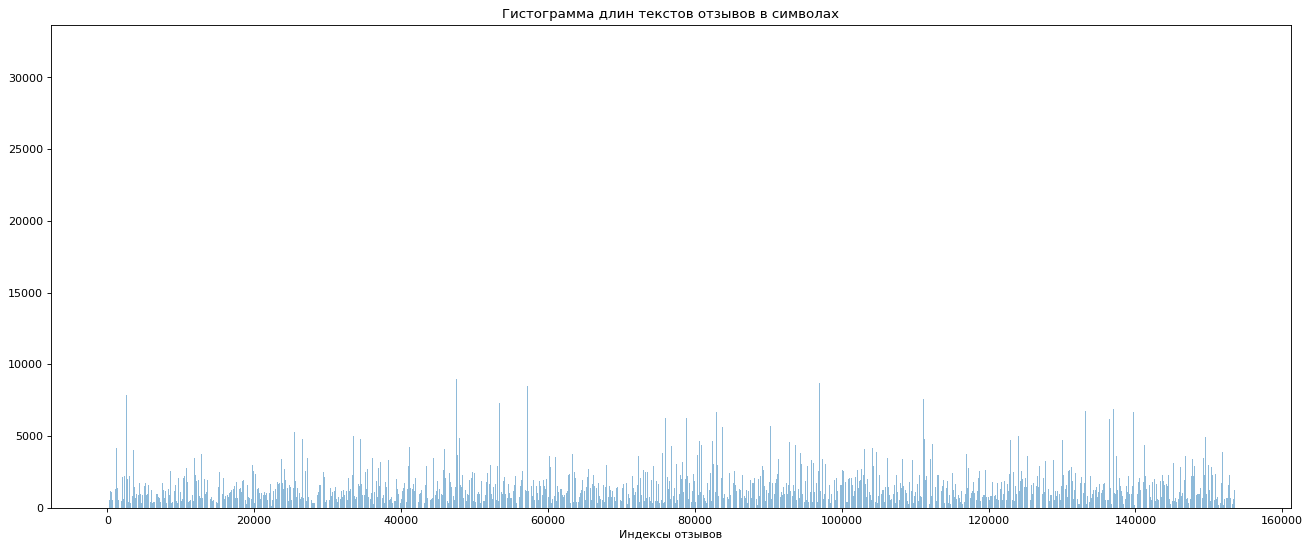

In [23]:
plt.figure(figsize=(20, 8), dpi=80)
plt.bar(df.index, lst_symb, align='center', alpha=0.5)
plt.xlabel("Индексы отзывов")
plt.title("Гистограмма длин текстов отзывов в символах")
plt.show()

In [24]:
del lst_symb

Данных много, поэтому видно не очень хорошо. Тем не менее, нельзя не заметить, что часть отзывов имеет порядка 8 - 9 тысяч символов.

И гистограмма длин текстов отзывов в словах. Поскольку слова выделены пробелами, рассплитуем каждый отзыв по пробелам:

In [25]:
lst_words = []
for i in df['text']:
    lst_words.append(len(i.split(" ")))

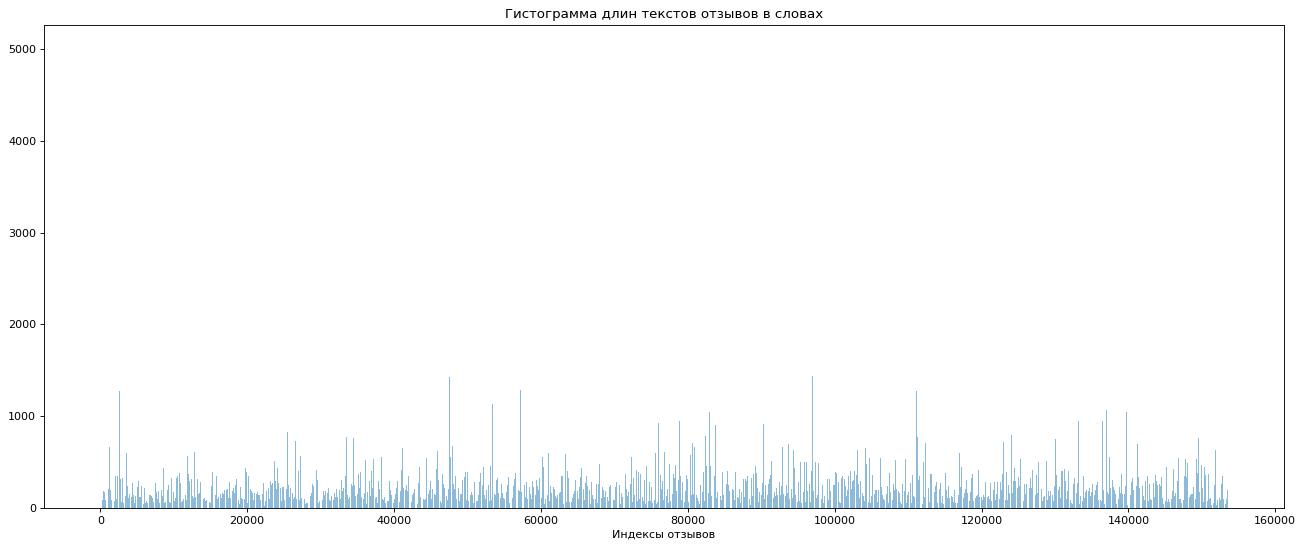

In [26]:
plt.figure(figsize=(20, 8), dpi=80)
plt.bar(df.index, lst_words, align='center', alpha=0.5)
plt.xlabel("Индексы отзывов")
plt.title("Гистограмма длин текстов отзывов в словах")
plt.show()

In [27]:
del lst_words

В среднем количество слов в отзывах варьируется от 200 до 700, но есть и отзывы с более чем 1500 слов. Данные вполне сопоставимы с предыдущей гистограммой. Логично, что "отличившиеся" объемом слов отзывы также имеют и большое количество символов.

#### 3. Найдите 10 самых частых:
 - слов


Итак, поскольку мы переходим непосредственно к работе с текстом, очистим его от цифр, лишних знаков и приведем к нижнему регистру:

In [28]:
#Используем регулярные выражения, чтобы разбить тексты на слова
import re
regex = re.compile("[А-Яа-яЁё]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

df.text.iloc[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности начиная с марта года начали приходить бесконечные письма из ооо примо коллект на мой адрес город москва уваровский переулок дом квартира с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор от года и договор от года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают закон о защи

In [29]:
def clear_text(text):     # очистим строки при помощи регулярных выражений: оставим только буквы.
    new_text = (re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)).lower()
    return " ".join(new_text.split())

In [30]:
%%time
clear_lst = []
for i in list(df['text']):
    clear_lst.append(clear_text(i))
clear_lst[:2]

CPU times: user 9.02 s, sys: 8 ms, total: 9.03 s
Wall time: 9.02 s


['добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности начиная с марта года начали приходить бесконечные письма из ооо примо коллект на мой адрес город москва уваровский переулок дом квартира с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор от года и договор от года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают закон о защ

In [31]:
%%time
df['clear_text'] = clear_lst
df.head()

CPU times: user 27.8 ms, sys: 81 µs, total: 27.9 ms
Wall time: 27 ms


,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,clear_text
0,г. Москва,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN,добрый день я не являюсь клиентом банка и пору...
1,г. Новосибирск,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN,доброго дня являюсь держателем зарплатной карт...
2,г. Москва,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до м...,NaN,здравствуйте дублирую свое заявление от в до м...
3,г. Ставрополь,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN,добрый день я открыл расчетный счет в сбербанк...
4,г. Челябинск,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною с...,NaN,г взяла кредит в вашем банке заявленная мною с...


Всё готово. Можем искать наиболее часто повторяющиеся слова:

In [32]:
corpus = []
for i in df['clear_text']:
    i = i.split(" ")
    corpus.append(i)

Придадим получившемуся корпусу слов одномерный вид:

In [33]:
import itertools
corpus = list(itertools.chain.from_iterable(corpus))
corpus[:10]

['добрый',
 'день',
 'я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по']

Проверим, какие слова являются наиболее частыми:

In [34]:
%%time
allWordDist = nltk.FreqDist(w for w in corpus)

CPU times: user 30.1 s, sys: 328 ms, total: 30.4 s
Wall time: 30.4 s


In [35]:
mostCommon= allWordDist.most_common(10)
mostCommon

[('в', 1330307),
 ('и', 1058997),
 ('не', 852432),
 ('на', 707803),
 ('что', 640057),
 ('я', 577500),
 ('с', 463027),
 ('по', 372759),
 ('мне', 320958),
 ('банка', 275906)]

Итак, самые популярные слова - это предлоги, союзы, одно местоимение и, наконец, слово "банк".

 - слов без стоп-слов

Загрузим стоп-слова

In [36]:
from nltk.corpus import stopwords
stopwords = stopwords.words('russian') + ['-', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'г', 'Добрый день', 'Здравствуйте', 'доброго', 'дня', 'добрый', 'день', 'здравствуйте', 'В', 'тут-то', 'было', 'На', 'чуть-чуть', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'Не', 'Как', 'без', 'рэ']

In [37]:
allWordExceptStopDist = nltk.FreqDist(w for w in corpus if w not in stopwords)    
mostCommonExceptStopDist= allWordExceptStopDist.most_common(10)
mostCommonExceptStopDist

[('банка', 275906),
 ('банк', 215425),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81135),
 ('банке', 72169),
 ('заявление', 70423),
 ('очень', 66824),
 ('отделение', 66647)]

Убрав стоп-слова, мы выделили 10 наиболее часто повторяющихся слов. Вполне логично, что все они связаны с банком. Особенно интересно попадание в топ-10 слова "очень". Мы не определили его в список стоп-слов, поэтому можем наблюдать частоту его употребления и сделать вывод, что большая часть клиентов пишет отзыв, основываясь на эмоциях.

 - лемм

Напишем функцию, в которой будем проводить лемматизацию (возвращать слова в инфинитив) и попутно проверять на часть речи:

In [38]:
def morph_word_lemma(key):
    meaningfullPoSes=['NPRO', 'PREP', 'CONJ', 'PRCL', 'INTJ'] # фильтруем граммемы
    reswords=[]
    morph = pymorphy2.MorphAnalyzer()
    tags = []

    for word in key:
        word_normal_form = morph.parse(word)[0].normal_form
        form = morph.parse(word)[0].tag
    
        if form.POS in meaningfullPoSes:
            continue
        else:
            reswords.append(word_normal_form)
            tags.append(form)

    return reswords, tags

И составляем словарь вида «Лемма: [количество упоминаний леммы]»:

In [39]:
def counter_dict_list(list_values):
    
    list_values_all=[]
        
    for item in list_values:
        list_values_all.append(item)
        dict_values_word_lemma = dict(Counter(list_values_all))
            
    sorted_dict_values_word_lemma = list(dict_values_word_lemma.items())
    sorted_dict_values_word_lemma.sort(key=lambda i: i[1], reverse=True)
    sorted_dict_values_word_lemma = dict(sorted_dict_values_word_lemma)

    return (sorted_dict_values_word_lemma)

Применяем:

In [40]:
words, tags = morph_word_lemma(corpus[1000:6000])

In [41]:
words[:10], tags[:10]

(['ещё',
  'подойти',
  'разобраться',
  'быть',
  'крайне',
  'удивлённый',
  'новость',
  'май',
  'унификация',
  'удивлённый'],
 [OpencorporaTag('ADVB'),
  OpencorporaTag('VERB,perf,intr masc,sing,past,indc'),
  OpencorporaTag('VERB,perf,intr plur,impr,excl'),
  OpencorporaTag('VERB,impf,intr masc,sing,past,indc'),
  OpencorporaTag('ADVB'),
  OpencorporaTag('ADJS,Qual masc,sing'),
  OpencorporaTag('NOUN,inan,femn sing,ablt'),
  OpencorporaTag('NOUN,inan,masc,Sgtm sing,gent'),
  OpencorporaTag('NOUN,inan,femn sing,gent'),
  OpencorporaTag('ADJS,Qual masc,sing')])

In [42]:
most_common_lemm = Counter(counter_dict_list(words)).most_common(10)
most_common_lemm

[('банк', 84),
 ('быть', 83),
 ('карта', 35),
 ('мой', 33),
 ('кредит', 25),
 ('мочь', 23),
 ('клиент', 23),
 ('уже', 23),
 ('который', 22),
 ('тот', 22)]

Итак, большая часть лемм также связана с банковской темой, но сюда же попали и местоимения, и союзы, и даже один глагол.

- существительных

In [43]:
index_noun = []
for i in range(len(tags)):
    if 'NOUN' in tags[i]:
        index_noun.append(i)

In [44]:
words_noun = [words[i] for i in range(len(words)) if i in index_noun]
words_noun[:10]

['новость',
 'май',
 'унификация',
 'эмоция',
 'унификация',
 'незаконность',
 'право',
 'сторона',
 'договор',
 'дело']

In [45]:
most_common_noun = Counter(counter_dict_list(words_noun)).most_common(10)
most_common_noun

[('банк', 84),
 ('карта', 35),
 ('кредит', 25),
 ('клиент', 23),
 ('день', 20),
 ('год', 20),
 ('платёж', 19),
 ('время', 18),
 ('работа', 17),
 ('раз', 17)]

Что и требовалось доказать.

#### 4. Постройте кривые Ципфа и Хипса

In [46]:
freq_dict = Counter(corpus)
freq_dict.most_common(20)

[('в', 1330307),
 ('и', 1058997),
 ('не', 852432),
 ('на', 707803),
 ('что', 640057),
 ('я', 577500),
 ('с', 463027),
 ('по', 372759),
 ('мне', 320958),
 ('банка', 275906),
 ('а', 233385),
 ('банк', 215425),
 ('как', 205680),
 ('но', 200418),
 ('за', 192851),
 ('то', 191820),
 ('меня', 187279),
 ('это', 183365),
 ('у', 178134),
 ('к', 177424)]

*Закон Ципфа*

Эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

В любом достаточно большом тексте ранг слова обратно пропорционален его частоте: $f = \frac{a}{r}$

$f$ – частота слова, $r$  – ранг слова, $a$  – параметр, для славянских языков – около 0.07

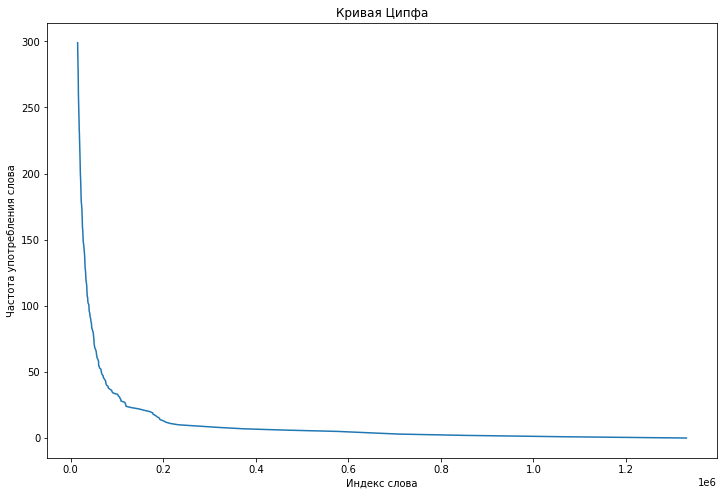

In [47]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)


fig, ax = plt.subplots(figsize=(12,8))
ax.plot(freqs[:300], range(300))
plt.xlabel('Индекс слова')
plt.ylabel('Частота употребления слова')
plt.title('Кривая Ципфа')
plt.show()

*Закон Хипса*

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

С увеличением длины текста (количества токенов), количество слов увеличивается в соответствии с законом: $|V| = K*N^b$


$N$  –  число токенов, $|V|$  – количество слов в словаре, $K, b$  –  параметры, обычно $K \in [10,100], b \in [0.4, 0.6]$

In [48]:
from tqdm import tqdm
from string import punctuation
from nltk.tokenize import word_tokenize

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
tokens_all = []
for index, row in tqdm(df[:1000].iterrows(), total = len(df[:1000])):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    tokens_all.append(tokens)
    n_words.append(len(cnt))
    n_tokens.append(list(sum(cnt.values())))

100%|██████████| 1000/1000 [00:01<00:00, 505.85it/s]


Преобразуем n_tokens в формат списка:

In [49]:
new_token = []
for i in n_tokens:
    t = []
    for j in i:
        if j != 1:
            t.append(j)
        else:
            continue
    new_token.append(t)

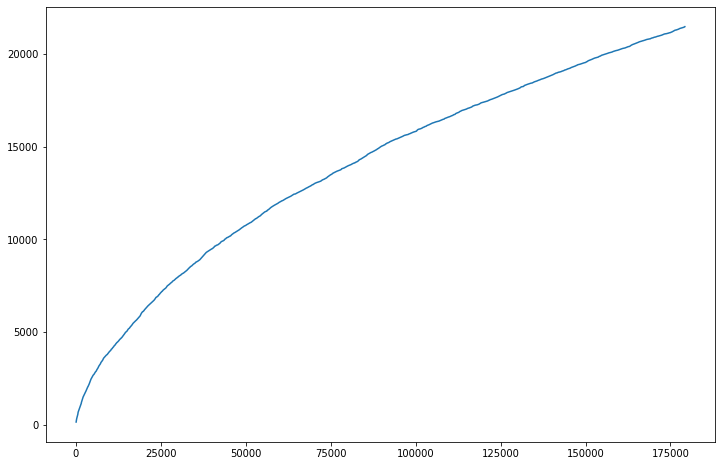

CPU times: user 840 ms, sys: 23.8 ms, total: 864 ms
Wall time: 861 ms


In [50]:
%%time
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([sum(i) for i in new_token], n_words)
plt.show()

#### 5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

In [51]:
from nltk import FreqDist

Преобразуем список списков в плоский список:

In [52]:
flat_list = [item for sublist in tokens_all for item in sublist]

И посмотрим, сколько же раз употребляются слова в нашем срезе:

In [53]:
print(FreqDist(flat_list)['сотрудник'])

178


In [54]:
print(FreqDist(flat_list)['клиент'])

121


In [55]:
print(FreqDist(flat_list)['мошенничество'])

9


In [56]:
print(FreqDist(flat_list)['доверие'])

20


Итак, с учетом того, что мы взяли лишь малую часть отзывов, можно сказать, что слово "сотрудник" встречается чаще, чем "клиент". При этом количество слов "доверие" больше, чем "мошенничество", и это радует.

#### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Этот столбец содержит много пропущенных значений. Занулим "Nanы" (будем считать, что рейтинг 0 - это отзыв без оценки):

In [57]:
df['rating_grade'] = df['rating_grade'].fillna(0)
df.head()

,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,clear_text
0,г. Москва,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,0.0,добрый день я не являюсь клиентом банка и пору...
1,г. Новосибирск,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,0.0,доброго дня являюсь держателем зарплатной карт...
2,г. Москва,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до м...,0.0,здравствуйте дублирую свое заявление от в до м...
3,г. Ставрополь,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,0.0,добрый день я открыл расчетный счет в сбербанк...
4,г. Челябинск,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною с...,0.0,г взяла кредит в вашем банке заявленная мною с...


Посмотрим, сколько оценок выставлено всего по каждой ступени шкалы:

In [58]:
df['rating_grade'].value_counts()

0.0    64841
1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

Вытащим из датафрейма строки с рейтингом 5 и 1. Разделим на 2 датафрейма: 

In [59]:
df_5 = df[df['rating_grade'] == 5.0][:5000]
df_1 = df[df['rating_grade'] == 1.0][:5000]

In [60]:
corpus_5 = df_5['clear_text'].values.astype('U')

In [61]:
corpus_1 = df_1['clear_text'].values.astype('U')

In [62]:
def tf_idf_analysis(keyword, ngram):
    
    v = TfidfVectorizer(min_df=2,analyzer='word',ngram_range=ngram,stop_words=stopwords)
    x = v.fit_transform(keyword)
    f = pd.DataFrame(x.toarray(), columns = v.get_feature_names())
    d=pd.concat([pd.DataFrame(f.mean(axis=0)),pd.DataFrame(f.max(axis=0))],axis=1)
    
    
    tf=pd.DataFrame((f>0).sum(axis=0))
    d=d.reset_index().merge(tf.reset_index(),on='index',how='left')
    d.columns=['word','average_tfidf','max_tfidf','frequency']
    d['frequency']=round((d['frequency']/len(keyword))*100)
    d = d.sort_values(by='average_tfidf', ascending=False)
    return d

In [63]:
tf_idf_analysis(corpus_5, (1, 1))[:10]

,word,average_tfidf,max_tfidf,frequency
677,банка,0.036185,0.243167,71.0
676,банк,0.031523,0.216617,63.0
14990,очень,0.027666,0.312804,55.0
4317,деньги,0.019194,0.293707,31.0
23757,спасибо,0.018784,0.204159,45.0
8037,карту,0.018490,0.298504,28.0
2027,вклад,0.018210,0.329678,21.0
681,банке,0.017642,0.175698,39.0
8038,карты,0.016838,0.414211,26.0
9076,кредит,0.016313,0.345375,20.0


In [64]:
tf_idf_analysis(corpus_1, (1, 1))[:10]

,word,average_tfidf,max_tfidf,frequency
604,банка,0.039494,0.244981,72.0
603,банк,0.031411,0.215071,62.0
4169,деньги,0.028385,0.364888,43.0
7784,карту,0.023222,0.320347,32.0
7785,карты,0.022602,0.356963,31.0
6542,заявление,0.019500,0.326677,30.0
13772,отделение,0.017618,0.214692,32.0
8672,кредит,0.017528,0.335810,23.0
4374,дней,0.015322,0.284778,28.0
23789,счет,0.015256,0.314469,23.0


И биграммы:

In [65]:
tf_idf_analysis(corpus_5, (2, 2))[:10]

,word,average_tfidf,max_tfidf,frequency
17722,интернет банк,0.007412,0.242950,11.0
20541,клиентом банка,0.005934,0.201431,9.0
59389,являюсь клиентом,0.005869,0.166809,9.0
10244,выразить благодарность,0.005735,0.216688,7.0
58063,хочу выразить,0.005698,0.164807,8.0
4773,большое спасибо,0.004811,0.306217,6.0
35222,очень быстро,0.004622,0.209632,6.0
30536,огромное спасибо,0.004473,0.274961,5.0
14696,других банках,0.004160,0.214394,6.0
35615,очень удобно,0.003894,0.247112,5.0


In [66]:
tf_idf_analysis(corpus_1, (2, 2))[:10]

,word,average_tfidf,max_tfidf,frequency
37027,отделение банка,0.007068,0.207141,11.0
12154,денежных средств,0.006724,0.249585,9.0
12146,денежные средства,0.006710,0.358506,8.0
10207,горячую линию,0.006328,0.220703,9.0
54895,сих пор,0.006068,0.264035,8.0
10203,горячей линии,0.005493,0.301914,7.0
57782,сотрудник банка,0.005158,0.322116,7.0
58025,сотрудники банка,0.005136,0.274626,8.0
25253,кредитную карту,0.004237,0.241274,5.0
4955,вашего банка,0.004230,0.365244,5.0


Что можно сказать: отличия есть, и существенные. Так, например, при рейтинге "5" клиенты пользуются интернет-банком, выражают благодарность, хвалят за быструю работу банка, интересуются вкладами. Касаемо рейтинга "1": клиенты обращаются на горячую линию, пишут о крединтых картах, долго ожидают решения вопроса, также часто пишут об смс-сообщениях.  
Вполне логично, что клиенты, поставившие "1", сталкиваются с проблемой и достаточно долгим ее решением.  
Клиенты же, поставившие "5", наоборот рады оперативному решению возникших вопросов.

Переходим к части 2.

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

#### 1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [67]:
import gensim
from gensim.corpora import Dictionary
from gensim import corpora, models
from gensim.models import  LsiModel, LdaModel, TfidfModel

/home/dev/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Для дальнейшей работы объединим срезы двух датафреймов (df_5 и df_1) и сделаем для них столбец с лемматизированными отзывами:

In [68]:
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip() 
    except:
        return " "
  
  
def  remove_stoplemmas(text, mystoplemmas = stopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""    
       
def preprocessing(text):
    lemmas = lemmatize(text)
    lemmas = remove_stoplemmas(lemmas)
    return(lemmas)

In [69]:
df_little = pd.concat([df_5, df_1]).sample(frac=1)

In [70]:
%%time
df_little['lemmatize_text'] = df['text'].apply(lambda x: preprocessing(x))

CPU times: user 6min 53s, sys: 1min 42s, total: 8min 35s
Wall time: 38min 26s


In [71]:
df_little.head()

,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,clear_text,lemmatize_text
1735,г. Зеленоград,Обман,1,лицензия № 1978,JuliaKir,Московский Кредитный Банк,2015-05-17 14:53:01,оформила у вас кредит в отделении г зеленоград...,1.0,оформила у вас кредит в отделении г зеленоград...,оформлять кредит отделение зеленоград номер до...
25952,г. Москва,"Прекрасное обслуживание в г. Красногорск, МО",0,лицензия № 1481,margo_2007,Сбербанк России,2014-11-22 12:35:00,добрый день хотелось бы поблагодарить сотрудни...,5.0,добрый день хотелось бы поблагодарить сотрудни...,хотеться поблагодарить сотрудник банк планиров...
18598,г. Чебоксары,Непрофессионализм?,4,лицензия № 3085,kukuruzica,Экспресс-Волга,2015-01-09 18:50:00,на мое имя был совершен перевод по системе лид...,1.0,на мое имя был совершен перевод по системе лид...,имя совершать перевод система лидер клятвенный...
12468,г. Москва,ВТБ24 реально достал звонками по ошибке,2,лицензия № 1623,xopowo,ВТБ 24,2015-02-23 13:06:08,в качестве небольшой предыстории учитывая бюдж...,1.0,в качестве небольшой предыстории учитывая бюдж...,качество небольшой предыстория учитывать бюдже...
15193,г. Москва,Банк названивает не клиенту и хамит,2,лицензия № 3251,albert.portman,Промсвязьбанк,2015-02-04 13:54:00,доброе время суток расскажу вам свою историю о...,1.0,доброе время суток расскажу вам свою историю о...,время сутки рассказывать свой история общение ...


Супер. Приступаем к тематическому моделированию:

In [72]:
texts = [df_little['lemmatize_text'].iloc[i].split() for i in range(len(df_little))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [73]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [77]:
lsi_10 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)
for t, top_words in lsi_10.print_topics(num_words=5):
    print('Topic', t, ":", top_words)

Topic 0 : 0.187*"карта" + 0.136*"вклад" + 0.130*"кредит" + 0.110*"деньги" + 0.103*"отделение"
Topic 1 : 0.437*"вклад" + 0.161*"открывать" + -0.153*"заявление" + 0.141*"очередь" + -0.125*"платеж"
Topic 2 : -0.384*"кредит" + 0.300*"карта" + -0.243*"страховка" + 0.234*"банкомат" + -0.158*"сделка"
Topic 3 : 0.535*"вклад" + -0.256*"карта" + 0.161*"договор" + -0.147*"сделка" + 0.146*"процент"
Topic 4 : 0.253*"карта" + 0.194*"комиссия" + 0.179*"лимит" + 0.175*"кредитный" + -0.171*"сбербанк"
Topic 5 : 0.360*"банкомат" + 0.277*"страховка" + -0.235*"номер" + -0.223*"звонок" + 0.170*"страхование"
Topic 6 : 0.318*"страховка" + 0.246*"карта" + -0.240*"платеж" + 0.203*"страхование" + -0.149*"банкомат"
Topic 7 : 0.267*"сделка" + -0.250*"банкомат" + -0.205*"кредит" + 0.180*"средство" + 0.160*"документ"
Topic 8 : 0.290*"сделка" + -0.262*"сбербанк" + 0.237*"заявка" + 0.171*"квартира" + -0.164*"страховка"
Topic 9 : -0.289*"сбербанк" + -0.276*"карта" + 0.205*"страховка" + 0.196*"номер" + 0.183*"банкомат"


In [78]:
lsi_15 = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=15)
for t, top_words in lsi_15.print_topics(num_words=5):
    print('Topic', t, ":", top_words)

Topic 0 : 0.187*"карта" + 0.136*"вклад" + 0.130*"кредит" + 0.110*"деньги" + 0.103*"отделение"
Topic 1 : 0.437*"вклад" + 0.160*"открывать" + -0.153*"заявление" + 0.141*"очередь" + -0.125*"платеж"
Topic 2 : -0.384*"кредит" + 0.301*"карта" + -0.243*"страховка" + 0.234*"банкомат" + -0.158*"сделка"
Topic 3 : 0.534*"вклад" + -0.257*"карта" + 0.160*"договор" + -0.146*"сделка" + 0.145*"процент"
Topic 4 : -0.253*"карта" + -0.192*"комиссия" + -0.176*"лимит" + -0.174*"кредитный" + 0.167*"банкомат"
Topic 5 : 0.361*"банкомат" + 0.278*"страховка" + -0.233*"номер" + -0.218*"звонок" + 0.170*"страхование"
Topic 6 : 0.316*"страховка" + 0.245*"карта" + -0.241*"платеж" + 0.199*"страхование" + -0.147*"банкомат"
Topic 7 : 0.266*"сделка" + -0.249*"банкомат" + -0.208*"кредит" + 0.177*"средство" + 0.158*"вклад"
Topic 8 : 0.290*"сделка" + 0.219*"заявка" + -0.206*"страховка" + -0.198*"сбербанк" + -0.180*"страхование"
Topic 9 : 0.341*"сбербанк" + 0.255*"карта" + -0.218*"банкомат" + -0.195*"номер" + 0.170*"погашен

In [82]:
from gensim.models.ldamulticore import LdaMulticore

In [84]:
lda_15 = LdaMulticore(corpus, num_topics=15, id2word = dictionary, passes=15, workers=5)
for t, top_words in lda_15.print_topics(num_words=5):
    print('Topic', t, ":", top_words)

Topic 0 : 0.025*"банк" + 0.016*"счет" + 0.012*"офис" + 0.010*"весь" + 0.009*"клиент"
Topic 1 : 0.021*"банк" + 0.020*"документ" + 0.015*"сделка" + 0.013*"весь" + 0.010*"сотрудник"
Topic 2 : 0.022*"ипотека" + 0.021*"заявка" + 0.020*"кредит" + 0.019*"документ" + 0.017*"банк"
Topic 3 : 0.043*"банк" + 0.011*"весь" + 0.010*"клиент" + 0.010*"год" + 0.008*"свой"
Topic 4 : 0.056*"вклад" + 0.024*"банк" + 0.017*"отделение" + 0.017*"открывать" + 0.015*"офис"
Topic 5 : 0.034*"деньги" + 0.030*"банкомат" + 0.025*"банк" + 0.019*"счет" + 0.016*"сумма"
Topic 6 : 0.040*"карта" + 0.023*"банк" + 0.014*"отделение" + 0.013*"заявление" + 0.012*"сбербанк"
Topic 7 : 0.030*"банк" + 0.019*"сотрудник" + 0.014*"клиент" + 0.010*"вопрос" + 0.009*"карта"
Topic 8 : 0.043*"банк" + 0.027*"вклад" + 0.018*"перевод" + 0.011*"процент" + 0.011*"деньги"
Topic 9 : 0.052*"карта" + 0.033*"банк" + 0.009*"интернет" + 0.008*"кредитный" + 0.008*"лимит"
Topic 10 : 0.030*"банк" + 0.010*"вопрос" + 0.008*"офис" + 0.007*"вклад" + 0.006*"в

Пример наиболее понятных тем:   
**lsi_15**:  
- Topic 1. Вероятно, клиент хотел открыть вклад, но была большая очередь;  
- Topic 12 : Был осуществлен перевод на счет;    

**lda_15**:  
- Topic 2. Была оставлена заявка в банке на ипотечный кредит;  
- Topic 5. Произошла ситуация с перевоом некой суммы денег через банкомат банка

#### 2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [89]:
%%time
lda_20 = LdaMulticore(corpus, num_topics=20, id2word = dictionary, passes=15, workers=5)
dct = {}
for t, top_words in lda_20.print_topics(num_words=8):
    dct['Topic {}'.format(t)] = top_words

CPU times: user 3min 50s, sys: 2min 11s, total: 6min 2s
Wall time: 3min 23s


Отсортируем только те темы, в которых указан Сбербанк:

In [94]:
for i in dct.values():
    if "сбербанк" in i:
        print(i)

0.106*"карта" + 0.023*"отделение" + 0.015*"сбербанк" + 0.012*"сотрудник" + 0.012*"банк" + 0.011*"получать" + 0.009*"заявление" + 0.009*"приходить"
0.030*"карта" + 0.025*"деньги" + 0.022*"банк" + 0.013*"банкомат" + 0.011*"заявление" + 0.011*"счет" + 0.011*"сбербанк" + 0.009*"операция"


Итак, в первой теме клиент пришел в отделение Сбербанка, где сотрудник получил от него заявление, касающееся карты.  
Во второй теме производилась операция, связанная с банкоматом и картой. Возможно, перевод (или получение) денег, но операция была неудачной, вследствие чего было написано заявление.

Касаемо банка ВТБ:

In [95]:
for i in dct.values():
    if "втб" in i:
        print(i)

0.016*"банк" + 0.011*"пд" + 0.007*"ответ" + 0.006*"заявка" + 0.005*"ваш" + 0.004*"проблема" + 0.004*"документ" + 0.004*"втб"
0.015*"банк" + 0.010*"счет" + 0.009*"который" + 0.007*"свой" + 0.005*"открывать" + 0.005*"втб" + 0.004*"документ" + 0.004*"мочь"


В первой теме фигурирует некий платежный документ, по которому была оставлена заявка в банке. Тема посвящена ответу по проблеме клиента в банке ВТБ.  

Во второй теме клиент хочет открыть счет в банке. Возможно, вопрос касается необходимых документов.

Переходим к части 3.

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

Вспомним, действительно ли мы отфильтровали только строки с рейтингом 5 и 1:

In [74]:
df_little.rating_grade.value_counts()

5.0    5000
1.0    5000
Name: rating_grade, dtype: int64

#### 1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое. 

Разделим выборку на обучающую и тестовую:

In [75]:
X = df_little['lemmatize_text']
y = df_little['rating_grade']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500,), (2500,), (7500,), (2500,))

#### 2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных 𝑛-грам. 

Попробуем сначала с символьными n-граммами:

In [77]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('clf', RandomForestClassifier()),
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("F1:",(f1_score(y_test, y_pred)))
print("ROC: ",(roc_auc_score(y_test, y_pred)))
print("Accuracy: ", (accuracy_score(y_test, y_pred)))
print("Classification report: \n", (classification_report(y_test, y_pred)))

F1: 0.9311836413684624
ROC:  0.9300624099179713
Accuracy:  0.93
Classification report: 
               precision    recall  f1-score   support

         1.0       0.94      0.93      0.93      1277
         5.0       0.92      0.93      0.93      1223

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



Униграммы:

In [78]:
clf_1 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=stopwords, ngram_range=(1,1))), 
    ('clf', RandomForestClassifier())

])

clf_1.fit(X_train, y_train)
y_pred_1 = clf_1.predict(X_test)

print("F1:",(f1_score(y_test, y_pred_1)))
print("ROC: ",(roc_auc_score(y_test, y_pred_1)))
print("Accuracy: ", (accuracy_score(y_test, y_pred_1)))
print("Classification report: \n", (classification_report(y_test, y_pred_1)))

F1: 0.9350447296771683
ROC:  0.9330218706839863
Accuracy:  0.9332
Classification report: 
               precision    recall  f1-score   support

         1.0       0.93      0.94      0.94      1277
         5.0       0.94      0.92      0.93      1223

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



Биграммы:

In [79]:
clf_2 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=stopwords, ngram_range=(2,2))), 
    ('clf', RandomForestClassifier())

])

clf_2.fit(X_train, y_train)
y_pred_2 = clf_2.predict(X_test)

print("F1:",(f1_score(y_test, y_pred_2)))
print("ROC: ",(roc_auc_score(y_test, y_pred_2)))
print("Accuracy: ", (accuracy_score(y_test, y_pred_2)))
print("Classification report: \n", (classification_report(y_test, y_pred_2)))

F1: 0.906576980568012
ROC:  0.8988987502008939
Accuracy:  0.9
Classification report: 
               precision    recall  f1-score   support

         1.0       0.87      0.95      0.91      1277
         5.0       0.94      0.85      0.89      1223

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500



Три слова:

In [80]:
clf_3 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=stopwords, ngram_range=(3,3))), 
    ('clf', RandomForestClassifier())

])

clf_3.fit(X_train, y_train)
y_pred_3 = clf_3.predict(X_test)

print("F1:",(f1_score(y_test, y_pred_3)))
print("ROC: ",(roc_auc_score(y_test, y_pred_3)))
print("Accuracy: ", (accuracy_score(y_test, y_pred_3)))
print("Classification report: \n", (classification_report(y_test, y_pred_3)))

F1: 0.8100481761871988
ROC:  0.7760542358642848
Accuracy:  0.7792
Classification report: 
               precision    recall  f1-score   support

         1.0       0.72      0.92      0.81      1277
         5.0       0.89      0.63      0.74      1223

    accuracy                           0.78      2500
   macro avg       0.80      0.78      0.77      2500
weighted avg       0.80      0.78      0.77      2500



А что, если n_gram сделать в интервале 4-6 (как в изначальном примере)?

In [81]:
clf_4 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=stopwords, ngram_range=(4,6))), 
    ('clf', RandomForestClassifier())

])

clf_4.fit(X_train, y_train)
y_pred_4 = clf_4.predict(X_test)

print("F1:",(f1_score(y_test, y_pred_4)))
print("ROC: ",(roc_auc_score(y_test, y_pred_4)))
print("Accuracy: ", (accuracy_score(y_test, y_pred_4)))
print("Classification report: \n", (classification_report(y_test, y_pred_4)))

F1: 0.7310999110584049
ROC:  0.6299511900272191
Accuracy:  0.6372
Classification report: 
               precision    recall  f1-score   support

         1.0       0.59      0.97      0.73      1277
         5.0       0.89      0.29      0.44      1223

    accuracy                           0.64      2500
   macro avg       0.74      0.63      0.59      2500
weighted avg       0.74      0.64      0.59      2500



Итак, лучше всего в даном случае сработали униграммы.

#### 3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: 𝑡𝑓−𝑖𝑑𝑓 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). 

*Вариант 1.*

In [82]:
clf_5 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=stopwords, ngram_range=(1,1))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

clf_5.fit(X_train, y_train)
y_pred_5 = clf_5.predict(X_test)

print("F1:",(f1_score(y_test, y_pred_5)))
print("ROC: ",(roc_auc_score(y_test, y_pred_5)))
print("Accuracy: ", (accuracy_score(y_test, y_pred_5)))
print("Classification report: \n", (classification_report(y_test, y_pred_5)))

F1: 0.7209119496855346
ROC:  0.7159538754401253
Accuracy:  0.716
Classification report: 
               precision    recall  f1-score   support

         1.0       0.72      0.72      0.72      1277
         5.0       0.71      0.71      0.71      1223

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



Использование скрытых тем в первом случае (при преобразовании tf-idf + сингулярном разложении) существенно уменьшило качество предсказания модели случайного леса.

*Вариант 2.*

In [83]:
clf_6 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=stopwords, ngram_range=(1,1))), 
    ('lda', LatentDirichletAllocation(n_components=2, random_state=42, n_jobs=-1)), 
    ('clf', RandomForestClassifier())
])

clf_6.fit(X_train, y_train)
y_pred_6 = clf_6.predict(X_test)

print("F1:",(f1_score(y_test, y_pred_6)))
print("ROC: ",(roc_auc_score(y_test, y_pred_6)))
print("Accuracy: ", (accuracy_score(y_test, y_pred_6)))
print("Classification report: \n", (classification_report(y_test, y_pred_6)))

F1: 0.7650578380534504
ROC:  0.7646962967041904
Accuracy:  0.7644
Classification report: 
               precision    recall  f1-score   support

         1.0       0.78      0.75      0.77      1277
         5.0       0.75      0.78      0.76      1223

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500



Стало несколько лучше,но всё равно результат далёк от предыдущих значений.

И еще попробуем обучить логистическую регрессию:

In [84]:
from sklearn.linear_model import LogisticRegression

clf_7 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=stopwords, ngram_range=(1,1))), 
    ('lda', LatentDirichletAllocation(n_components=2, random_state=42, n_jobs=-1)), 
    ('clf', LogisticRegression())
])

clf_7.fit(X_train, y_train)
y_pred_7 = clf_7.predict(X_test)

print("F1:",(f1_score(y_test, y_pred_7)))
print("ROC: ",(roc_auc_score(y_test, y_pred_7)))
print("Accuracy: ", (accuracy_score(y_test, y_pred_7)))
print("Classification report: \n", (classification_report(y_test, y_pred_7)))

F1: 0.8586057502953918
ROC:  0.8564626312052152
Accuracy:  0.8564
Classification report: 
               precision    recall  f1-score   support

         1.0       0.86      0.85      0.86      1277
         5.0       0.85      0.86      0.85      1223

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



А вот логистическая регрессия в данном случае справилась намного лучше. В данной задаче лучше использовать ее.

Таким образом, можно сказать, что наилучший результат получился при векторизации с параметром ngram_range=(1,1), а при добавлении скрытых тем - с моделью LDA. При этом модель логистической регрессии в совокупности с LDA и векторизацией с униграммами показала результат лучше, чем случайный лес (гиперпараметры модели не перебирались). 
Поэтому в данном случае лучше всего использовать модель случайного леса и векторизацию текста с использованием униграмм: самые высокие оценки качества показал именно этот вариант (F1: 0.935; Accuracy:  0.933).